In [1]:
import tensorflow as tf

In [2]:
from cifar_data import get_file_queue

In [3]:
q = get_file_queue()

In [4]:
s = q.dequeue()

sess = tf.Session()
sess.run(tf.initialize_all_variables())
s.eval(session=sess)

In [5]:
def provide_batch(train_test, batch_size, training):
    if train_test == 'train':
        filenames = [('/tmp/cifar10_data/cifar-10-batches-bin/data_batch_%d.bin' % i) for i in range(1, 6)]
    if train_test == 'test':
        filenames = ['/tmp/cifar10_data/cifar-10-batches-bin/test_batch.bin']
    # Create a queue of with the file names and shuffle them, only the file names
    filename_queue = tf.train.string_input_producer(filenames, shuffle=True)
    # Create a reader that reads 32*32*3+1 bytes from the file, the first byte is the label
    # and the rest 32*32*3 bytes correspong to the RGB square image of size 32
    reader = tf.FixedLengthRecordReader(record_bytes=32 * 32 * 3 + 1)
    # Create the operation that reads 3073 bytes from the file and puts it in 'value'
    key, value = reader.read(filename_queue)
    # We decode the bits as bytes with uint8: unsigned integers of 8 bits.
    record_bytes = tf.decode_raw(value, tf.uint8)
    # We cut the first byte that corresponds to the label
    bytes_label = tf.slice(input_=record_bytes, begin=[0], size=[1])
    # The final label tensor is of type int32
    label_tensor = tf.cast(bytes_label, tf.int32)
    # We cut the bytes corresponding to the image
    bytes_image = tf.slice(input_=record_bytes, begin=[1], size=[32 * 32 * 3])
    # We reshape them first cutting it into the 3 channels (3 portions) and then organizing
    # the rows and the columns of each channel
    depth_major = tf.reshape(bytes_image, [3, 32, 32])
    # We reshape it and obtain the bytes of the image, i.e. a uint8 image tensor
    uint8_image_tensor = tf.transpose(depth_major, [1, 2, 0])
    # We cast it as float since we want to make operations with it
    image_tensor = tf.cast(uint8_image_tensor, tf.float32)

    nb_threads = 20
    min_after_dequeue = batch_size * 100
    safety_margin = 5
    capacity = min_after_dequeue + (nb_threads + safety_margin) * batch_size

    if training:
        image_tensor = tf.image.random_flip_left_right(image_tensor)
        image_tensor = tf.pad(image_tensor, [[4, 4], [4, 4], [0, 0]])
        image_tensor = tf.random_crop(image_tensor, [32, 32, 3])
        image_tensor = tf.image.random_brightness(image_tensor, max_delta=63)
        image_tensor = tf.image.random_contrast(image_tensor, lower=0.2, upper=1.8)
        image_tensor = tf.image.per_image_whitening(image_tensor)
        batch_images_tensor, pre_batch_labels_tensor = tf.train.shuffle_batch([image_tensor, label_tensor],
                                                                              batch_size=batch_size,
                                                                              num_threads=nb_threads,
                                                                              capacity=capacity,
                                                                              min_after_dequeue=min_after_dequeue)
        # batch_images_tensor = tf.image.rgb_to_grayscale(batch_images_tensor)
        tf.image_summary('images_train', batch_images_tensor, max_images=10)
    if not training:
        image_tensor = tf.image.per_image_whitening(image_tensor)
        batch_images_tensor, pre_batch_labels_tensor = tf.train.batch([image_tensor, label_tensor],
                                                                      batch_size=batch_size,
                                                                      num_threads=nb_threads,
                                                                      capacity=capacity)
        # batch_images_tensor = tf.image.rgb_to_grayscale(batch_images_tensor)
        tf.image_summary('images_test', batch_images_tensor, max_images=10)
    batch_labels_tensor = tf.reshape(pre_batch_labels_tensor, [batch_size])
    return batch_images_tensor, batch_labels_tensor


In [6]:
batch = provide_batch('train', 128, True)

In [7]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [8]:
batch

(<tf.Tensor 'shuffle_batch:0' shape=(128, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'Reshape_1:0' shape=(128,) dtype=int32>)

In [10]:
coord = tf.train.Coordinator()

In [11]:
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

In [12]:
b = sess.run(batch[0])

In [13]:
b.shape

(128, 32, 32, 3)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

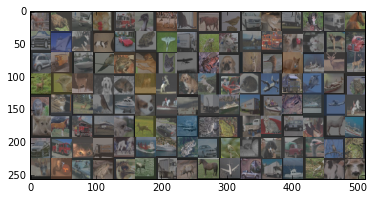

In [16]:
plt.imshow((b.reshape(8, 16, 32, 32, 3).transpose(0, 2, 1, 3, 4).reshape(256, 512, 3) - b.min()) / b.ptp() )

In [17]:
50000 * 32 * 32 * 3 * 8 / (1024 ** 3)

1.1444091796875

In [3]:
import numpy as np

In [4]:
dt = np.dtype([('label', np.uint8, (1,)), ('image', np.uint8, (3, 32, 32))])

In [5]:
dt

dtype([('label', 'u1', (1,)), ('image', 'u1', (3, 32, 32))])

In [6]:
a = np.zeros(5, dtype=dt)

In [39]:
f = '/tmp/cifar10_data/cifar-10-batches-bin/data_batch_1.bin'
c = np.fromfile(f, dtype=dt)

In [43]:
c['image'].shape

(10000, 3, 32, 32)

(-0.5, 31.5, 31.5, -0.5)

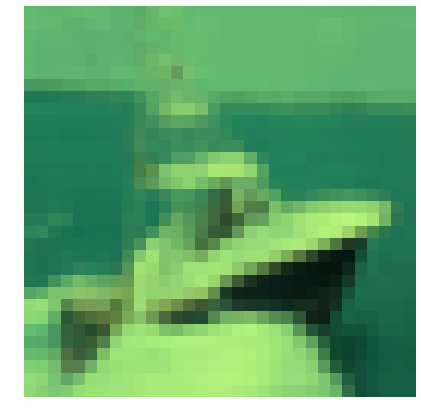

In [38]:
plt.figure(figsize=(7, 7))
plt.imshow((c[8]['image'].transpose(1, 2, 0) * np.array((.75, 1., .5)) / 256), interpolation='nearest')
plt.axis('off')

In [10]:
c['label'][100]

array([8], dtype=uint8)

In [11]:
cifar = tf.Variable(c['image'])

In [12]:
cifar_queue = tf.train.input_producer(cifar)
q = cifar_queue.dequeue()
cifar_batch = tf.train.batch([q], batch_size=128)

In [13]:
coord = tf.train.Coordinator()
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [14]:
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

In [20]:
r = sess.run(q)

In [21]:
r.shape

(3, 32, 32)

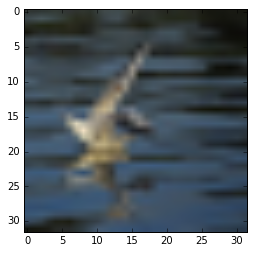

In [22]:
plt.imshow(r.transpose(1, 2, 0))

In [23]:
s = sess.run(cifar_batch)

In [24]:
s.shape

(128, 3, 32, 32)